## Feature Selection

Here we'll figure out which features are best to use for prediction.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import KFold

from catboost import CatBoostRegressor

# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()

## Data Loading

We engineered features and saved them to a feather file in the "Elo Feature Engineering" kernel.  Let's load that data back in here:

In [2]:
# Load data containing all the features
fname = '../input/elo-feature-engineering/card_features_all.feather'
cards = pd.read_feather(fname)
cards.set_index('card_id', inplace=True)

# Keep only the training data
cards_train = cards[~cards['target'].isnull()]
del cards
gc.collect()

/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


29

In [3]:
cards_train.sample(10)

,first_active_month,feature_1,feature_2,feature_3,target,hist_authorized_flag_sum,new_authorized_flag_sum,hist_authorized_flag_mean,hist_authorized_flag_nunique,hist_city_id_nunique,new_city_id_nunique,hist_city_id_entropy,new_city_id_entropy,hist_city_id_mode,new_city_id_mode,hist_category_1_sum,new_category_1_sum,hist_category_1_mean,new_category_1_mean,hist_category_1_nunique,new_category_1_nunique,hist_installments_min,new_installments_min,hist_installments_max,new_installments_max,hist_installments_sum,new_installments_sum,hist_installments_mean,new_installments_mean,hist_installments_std,new_installments_std,hist_installments_skew,new_installments_skew,hist_installments_mean_diff,new_installments_mean_diff,hist_installments_period,new_installments_period,hist_category_3_nunique,new_category_3_nunique,hist_category_3_entropy,...,hist_avg_sales_lag12_period,new_avg_sales_lag12_period,hist_avg_purchases_lag12_min,new_avg_purchases_lag12_min,hist_avg_purchases_lag12_max,new_avg_purchases_lag12_max,hist_avg_purchases_lag12_sum,new_avg_purchases_lag12_sum,hist_avg_purchases_lag12_mean,new_avg_purchases_lag12_mean,hist_avg_purchases_lag12_std,new_avg_purchases_lag12_std,hist_avg_purchases_lag12_skew,new_avg_purchases_lag12_skew,hist_avg_purchases_lag12_mean_diff,new_avg_purchases_lag12_mean_diff,hist_avg_purchases_lag12_period,new_avg_purchases_lag12_period,hist_active_months_lag12_min,new_active_months_lag12_min,hist_active_months_lag12_max,new_active_months_lag12_max,hist_active_months_lag12_sum,new_active_months_lag12_sum,hist_active_months_lag12_mean,new_active_months_lag12_mean,hist_active_months_lag12_std,new_active_months_lag12_std,hist_active_months_lag12_skew,new_active_months_lag12_skew,hist_active_months_lag12_mean_diff,new_active_months_lag12_mean_diff,hist_active_months_lag12_period,new_active_months_lag12_period,hist_category_4_sum,new_category_4_sum,hist_category_4_mean,new_category_4_mean,hist_category_4_nunique,new_category_4_nunique
card_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
156236,76.0,3,2,1,-1.505788,7.0,1.0,0.218750,2.0,2.0,1.0,0.337290,-0.000000,214.0,214.0,0.0,0.0,0.000000,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.0,0.0,1.0,1.0,-0.000000,...,0.403075,0.000000,0.676964,0.903793,1.085526,0.903793,28.489611,0.903793,0.890300,0.903793,0.097193,NaN,-1.113000,NaN,0.013179,NaN,0.408562,0.000000,12.0,12.0,12.0,12.0,384.0,12.0,12.000000,12.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,1.0
223800,58.0,3,1,1,-0.641945,61.0,5.0,0.693182,2.0,2.0,2.0,0.156491,0.721928,158.0,158.0,0.0,0.0,0.000000,0.000000,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.011364,0.000000,0.106600,0.000000,9.380832,0.000000,0.011494,0.0000,1.0,0.0,2.0,1.0,0.089703,...,1.199103,0.360665,0.061653,0.583434,1.328655,0.871720,77.279221,3.712617,0.878173,0.742523,0.122185,0.144037,-2.898109,-0.554245,0.014563,0.072071,1.267002,0.288286,7.0,12.0,12.0,12.0,1051.0,60.0,11.943182,12.000000,0.533002,0.000000,-9.380832,0.000000,0.057471,0.0000,5.0,0.0,81.0,3.0,0.920455,0.600000,2.0,2.0
213300,47.0,5,1,1,-1.525177,25.0,17.0,1.000000,1.0,3.0,4.0,1.163990,1.658980,117.0,117.0,0.0,1.0,0.000000,0.058824,1.0,2.0,-1.0,-1.0,8.0,6.0,41.0,24.0,1.640000,1.411765,2.038790,1.872793,1.463816,1.126805,0.375000,0.4375,9.0,7.0,2.0,2.0,0.998364,...,0.990690,1.770106,0.721582,0.061653,1.527791,1.850706,23.943344,15.869895,0.957734,0.933523,0.162126,0.348814,1.857791,0.266970,0.033592,0.111816,0.806209,1.789052,12.0,7.0,12.0,12.0,300.0,197.0,12.000000,11.588235,0.000000,1.277636,0.000000,-3.381104,0.000000,0.3125,0.0,5.0,7.0,4.0,0.280000,0.235294,2.0,2.0
73437,72.0,3,1,1,5.298940,32.0,NaN,0.820513,2.0,2.0,NaN,0.732067,NaN,289.0,NaN,0.0,NaN,0.000000,NaN,1.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.0,NaN,1.0,NaN,-0.000000,...,1.199103,NaN,0.061653,NaN,1.409194,NaN,33.719017,NaN,0.864590,NaN,0.372742,NaN,-0.

## Mutual Information between Features and Target

Just to get some idea of how well each feature corresponds to the target, we can compute the mutual information between each feature and the target.  Let's make a function to compute the mutual information between two vectors.  We'll use the mutual information of the quantile-transformed aggregation scores (just so outliers don't mess up the mutual information calculation).

In [4]:
def quantile_transform(v, res=101):
    """Quantile-transform a vector to lie between 0 and 1"""
    x = np.linspace(0, 100, res)
    prcs = np.nanpercentile(v, x)
    return np.interp(v, prcs, x/100.0)
    
def mutual_information(xi, yi, res=20):
    """Compute the mutual information between two vectors"""
    ix = ~(np.isnan(xi) | np.isinf(xi) | np.isnan(yi) | np.isinf(yi))
    x = xi[ix]
    y = yi[ix]
    N, xe, ye = np.histogram2d(x, y, res)
    Nx, _ = np.histogram(x, xe)
    Ny, _ = np.histogram(y, ye)
    N = N / len(x) #normalize
    Nx = Nx / len(x)
    Ny = Ny / len(y)
    Ni = np.outer(Nx, Ny)
    Ni[Ni == 0] = np.nan
    N[N == 0] = np.nan
    return np.nansum(N * np.log(N / Ni))
    
def q_mut_info(x, y):
    """Compute the mutual information between two quantile-transformed vectors"""
    return mutual_information(quantile_transform(x),
                              quantile_transform(y))

And just to test that those functions work:

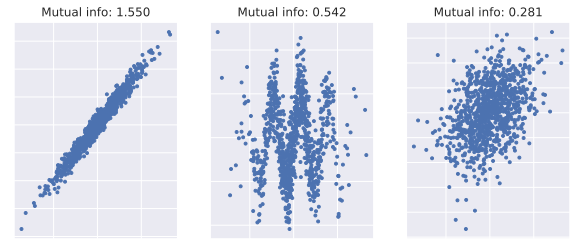

In [5]:
# Show mutual information plots
x = 5*np.random.randn(1000)
y = [x + np.random.randn(1000),
     2*np.sin(x) + np.random.randn(1000),
     x + 10*np.random.randn(1000)]
plt.figure(figsize=(10, 4))
for i in range(3):    
    plt.subplot(1, 3, i+1)
    plt.plot(x, y[i], '.')
    plt.title('Mutual info: %0.3f' % q_mut_info(x, y[i]))
    plt.gca().tick_params(labelbottom=False, labelleft=False)

And now we can actually compute the MI between each column and the target:

In [6]:
# Perform each aggregation and compute MI between the agg and target
mis = []
for col in cards:
    if 'mode' in col: continue #need to target-encode these first
    mi = q_mut_info(cards[col], cards['target'])
    mis.append([col, mi])

# Show mutual information between the target and each feature
mi_df = (pd.DataFrame(mis, columns=['Column', 'Mutual_Information'])
            .sort_values('Mutual_Information', ascending=False))
print(mi_df.to_string())

NameError: name 'cards' is not defined

## Target-Encoding the Categorical Columns

Before fitting a model, we'll want to somehow encode the categorical columns (like `state_id`, `merchant_category_id`, etc).  We can use "target encoding", where you replace the category values (e..g A, B, and C) with the mean of the target (in our case the loyalty score) for examples with that category.  I.e., for all the rows with category A, take the mean target value of those rows and replace A with that mean value, then do the same for B, etc...

But, we can't just do that willy-nilly to the whole dataframe - if we have a bunch of categories (which is the case for a lot of these categorical columns), then information from the y variable is leaking into the X variable.  Which, yes, is the point - but we want to do that across samples, not within the same sample. That is, we don't want to fit these encoded values to the same data we "train" them on.  So first we'll build a cross-validated target encoder (can't use sklearn-contrib's categorical-encoding package, b/c it doesn't have cross-validated target encoding, and it requires the indexes to match between calls to fit() and transform() - but we need the indexes to not match in order to fit on train data and transform on test data).

Here's the target encoder:

In [7]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    """Target encoder.
    
    Replaces categorical column(s) with the mean target value for
    each category.


    """
    
    def __init__(self, cols=None):
        """Target encoder
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.  Default is to target-encode all 
            categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):
        """Perform the target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

And the cross-validated target encoder:

In [8]:
class TargetEncoderCV(TargetEncoder):
    """Cross-validated target encoder.

    Note
    ----
    You must call transform() on the same dataset to which you fit().
    """
    
    def __init__(self, n_splits=3, shuffle=True, cols=None):
        """Cross-validated target encoding for categorical features.
        
        Parameters
        ----------
        n_splits : int
            Number of cross-validation splits. Default = 3.
        shuffle : bool
            Whether to shuffle the data when splitting into folds.
        cols : list of str
            Columns to target encode.
        """
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.cols = cols
        

    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        self._target_encoder = TargetEncoder(cols=self.cols)
        self._target_encoder.fit(X, y)
        return self

    
    def transform(self, X, y=None):
        """Perform the target encoding transformation.

        Uses cross-validated target encoding for the training fold, and uses
        normal target encoding for the test fold.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """

        # Use target encoding from fit() if this is test data
        if y is None:
            return self._target_encoder.transform(X)

        # Compute means for each fold
        self._train_ix = []
        self._test_ix = []
        self._fit_tes = []
        kf = KFold(n_splits=self.n_splits, shuffle=self.shuffle)
        for train_ix, test_ix in kf.split(X):
            self._train_ix.append(train_ix)
            self._test_ix.append(test_ix)
            te = TargetEncoder(cols=self.cols)
            if isinstance(X, pd.DataFrame):
                self._fit_tes.append(te.fit(X.iloc[train_ix,:],
                                            y.iloc[train_ix]))
            elif isinstance(X, np.ndarray):
                self._fit_tes.append(te.fit(X[train_ix,:], y[train_ix]))
            else:
                raise TypeError('X must be DataFrame or ndarray')

        # Apply means across folds
        Xo = X.copy()
        for ix in range(len(self._test_ix)):
            test_ix = self._test_ix[ix]
            if isinstance(X, pd.DataFrame):
                Xo.iloc[test_ix,:] = self._fit_tes[ix].transform(X.iloc[test_ix,:])
            elif isinstance(X, np.ndarray):
                Xo[test_ix,:] = self._fit_tes[ix].transform(X[test_ix,:])
            else:
                raise TypeError('X must be DataFrame or ndarray')
        return Xo

            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

## Baseline model

Let's build a basic modeling pipeline.  The pipeline target-encodes the categorical columns, normalizes the values for each column, fills in missing values with the median of their column, and uses [CatBoost](https://catboost.ai/) to predict the loyalty score.

In [9]:
# Regression pipeline
cat_cols = [c for c in cards_train if 'mode' in c] 
reg_pipeline = Pipeline([
    ('target_encoder', TargetEncoderCV(cols=cat_cols)),
    ('scaler', RobustScaler()),
    ('imputer', SimpleImputer(strategy='median')),
    ('regressor', CatBoostRegressor(loss_function='RMSE'))
])

## Permutation-based feature importance

Ideally we'd fit a model with each combination of features and use the set of features which gives the best cross-validated results.  But, that'll lead to overfitting to the training data, and also it would take forever.  So, let's just take the model fit with all the data (in the previous section), and compute permutation-based feature importances for each feature (based on how worse the model performs when you shuffle the data in one column).

First we need a function to compute the permutation-based feature importance given a *fit* model and some validation data (data the model was not fit on).

In [10]:
def permutation_importance(X, y, estimator, metric):
    """Compute permutation-based feature importance on validation data.
    
    Parameters
    ----------
    X : pandas DataFrame of size (Nsamples, Nfeatures)
        Features
    y : pandas Series or numpy ndarray of size (Nsamples,)
        Target
    estimator : sklearn estimator
        A fit model to use for prediction.
    metric : callable
        Metric to use for computing feature importance.  Larger should be 
        better.  If a callable, should take two arguments ``y_true`` and 
        ``y_pred`` and return a loss, where larger values indicate better
        performance.  If a string, possible values are:

        * ``'r2'`` - coefficient of variation (for regressors)
        * ``'mse'`` - mean squared error (for regressors)
        * ``'mae'`` - mean absolute error (for regressors)
        * ``'accuracy'`` or ``'acc'`` - accuracy (for classifiers)
        * ``'auc'`` - area under the ROC curve (for classifiers)

    Returns
    -------
    pandas DataFrame
        Importance scores of each feature.  Of size (1,Nfeatures)
    """

    # Check inputs
    if not isinstance(X, pd.DataFrame):
        raise TypeError('X must be a pandas DataFrame')
    if not isinstance(y, (pd.Series, np.ndarray)):
        raise TypeError('y must be a pandas Series or numpy vector')
    if X.shape[0] != y.shape[0]:
        raise ValueError('X and y must have the same number of samples')
    if not isinstance(estimator, BaseEstimator):
        raise TypeError('estimator must be an sklearn estimator')

    # Determine metric to use
    if metric == 'r2':
        metric_func = lambda t, p: r2_score(t, p)
    elif metric == 'mse':
        metric_func = lambda t, p: -mean_squared_error(t, p)
    elif metric == 'mae':
        metric_func = lambda t, p: -mean_absolute_error(t, p)
    elif metric == 'accuracy' or metric == 'acc':
        metric_func = lambda t, p: accuracy_score(t, p)
    elif metric == 'auc':
        metric_func = lambda t, p: roc_auc_score(t, p)
    elif hasattr(metric, '__call__'):
        metric_func = metric
    else:
        raise ValueError('metric must be a metric string or a callable')

    # Baseline performance
    base_score = metric_func(y, estimator.predict(X))

    # Permute each column and compute drop in metric
    importances = pd.DataFrame(np.zeros((1,X.shape[1])), columns=X.columns)
    for iC in X.columns:
        tC = X[iC].copy()
        X[iC] = X[iC].sample(frac=1, replace=True).values
        shuff_score = metric_func(y, estimator.predict(X))
        importances.loc[0,iC] = base_score - shuff_score
        X[iC] = tC

    # Return df with the feature importances
    return importances

Then we need to be able to compute the cross-validated feature importance:

In [11]:
def permutation_importance_cv(X, y, estimator, metric, 
                              n_splits=3, shuffle=True):
    """Compute cross-validated permutation-based feature importance.
    
    Parameters
    ----------
    X : pandas DataFrame
        Features
    y : pandas Series or numpy ndarray
        Target
    estimator : sklearn estimator
        Model to use for prediction.  For example, a pipeline object.
    metric : callable
        Metric to use for computing feature importance.  Larger should be 
        better.  If a callable, should take two arguments ``y_true`` and 
        ``y_pred`` and return a loss, where larger values indicate better
        performance.  If a string, possible values are:

        * ``'r2'`` - coefficient of variation (for regressors)
        * ``'mse'`` - mean squared error (for regressors)
        * ``'mae'`` - mean absolute error (for regressors)
        * ``'accuracy'`` - accuracy (for classifiers)
        * ``'auc'`` - area under the ROC curve (for classifiers)

    n_splits : int
        Number of cross-validation splits.  Default = 2.
    shuffle : bool
        Whether to shuffle when splitting into CV folds.  Default = True.

    Returns
    -------
    pandas DataFrame
        Importance scores of each feature for each cross-validation fold.
        Of size (n_splits, Nfeatures)
    """

    # Check inputs
    if not isinstance(X, pd.DataFrame):
        raise TypeError('X must be a pandas DataFrame')
    if not isinstance(y, (pd.Series, np.ndarray)):
        raise TypeError('y must be a pandas Series or numpy vector')
    if X.shape[0] != y.shape[0]:
        raise ValueError('X and y must have the same number of samples')
    if not isinstance(estimator, BaseEstimator):
        raise TypeError('estimator must be an sklearn estimator')
    if not isinstance(n_splits, int):
        raise TypeError('n_splits must be an integer')
    if n_splits < 1:
        raise ValueError('n_splits must be 1 or greater')
    if not isinstance(shuffle, bool):
        raise TypeError('shuffle must be True or False')

    # Compute feature importances for each fold
    importances = pd.DataFrame(np.zeros((n_splits,X.shape[1])),
                               columns=X.columns)
    kf = KFold(n_splits=n_splits, shuffle=shuffle)
    iF = 0
    for train_ix, test_ix in kf.split(X):
        t_est = clone(estimator)
        t_est.fit(X.iloc[train_ix,:], y.iloc[train_ix])
        t_imp = permutation_importance(X.iloc[test_ix,:].copy(),
                                       y.iloc[test_ix].copy(),
                                       t_est, metric)
        importances.loc[iF,:] = t_imp.loc[0,:]
        iF += 1

    # Return df with the feature importances for each fold
    return importances

And we'll also want to be able to plot the feature importances:

In [12]:
def plot_permutation_importance(importances):
    """Plot importance score of each feature.

    Parameters
    ----------
    importances : pandas DataFrame
        Importance scores for each feature.  Should be of shape 
        (Nfolds,Nfeatures).
    """
    df = pd.melt(importances, var_name='Feature', value_name='Importance')
    dfg = (df.groupby(['Feature'])['Importance']
           .aggregate(np.median)
           .reset_index()
           .sort_values('Importance', ascending=False))
    sns.barplot(x='Importance', y='Feature', data=df, order=dfg['Feature'])

Now, we can compute the importance of our features (when fitting the model with ALL the features).

In [13]:
# TODO: just do a small subset of the data for now
cards_train = cards_train.iloc[:10000,:]

In [14]:
# Split into features and target
cards_train.reset_index(drop=True, inplace=True)
y = cards_train['target'].copy()
del cards_train['target']
X = cards_train

In [15]:
%time

# Compute the cross-validated feature importance
imp_df = permutation_importance_cv(X, y, reg_pipeline, 'mse')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.2 µs
0:	learn: 3.6977080	total: 302ms	remaining: 5m 1s
1:	learn: 3.6916524	total: 475ms	remaining: 3m 57s
2:	learn: 3.6840740	total: 651ms	remaining: 3m 36s
3:	learn: 3.6761610	total: 831ms	remaining: 3m 27s
4:	learn: 3.6698458	total: 1s	remaining: 3m 19s
5:	learn: 3.6619164	total: 1.18s	remaining: 3m 15s
6:	learn: 3.6564022	total: 1.37s	remaining: 3m 14s
7:	learn: 3.6492220	total: 1.56s	remaining: 3m 13s
8:	learn: 3.6444202	total: 1.74s	remaining: 3m 12s
9:	learn: 3.6369275	total: 1.94s	remaining: 3m 12s
10:	learn: 3.6310725	total: 2.19s	remaining: 3m 17s
11:	learn: 3.6253923	total: 2.44s	remaining: 3m 21s
12:	learn: 3.6164425	total: 2.71s	remaining: 3m 25s
13:	learn: 3.6105962	total: 2.96s	remaining: 3m 28s
14:	learn: 3.6049193	total: 3.22s	remaining: 3m 31s
15:	learn: 3.5991033	total: 3.47s	remaining: 3m 33s
16:	learn: 3.5901921	total: 3.73s	remaining: 3m 35s
17:	learn: 3.5843301	total: 3.98s	remaining: 3m 37s
18:	learn: 3.57

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


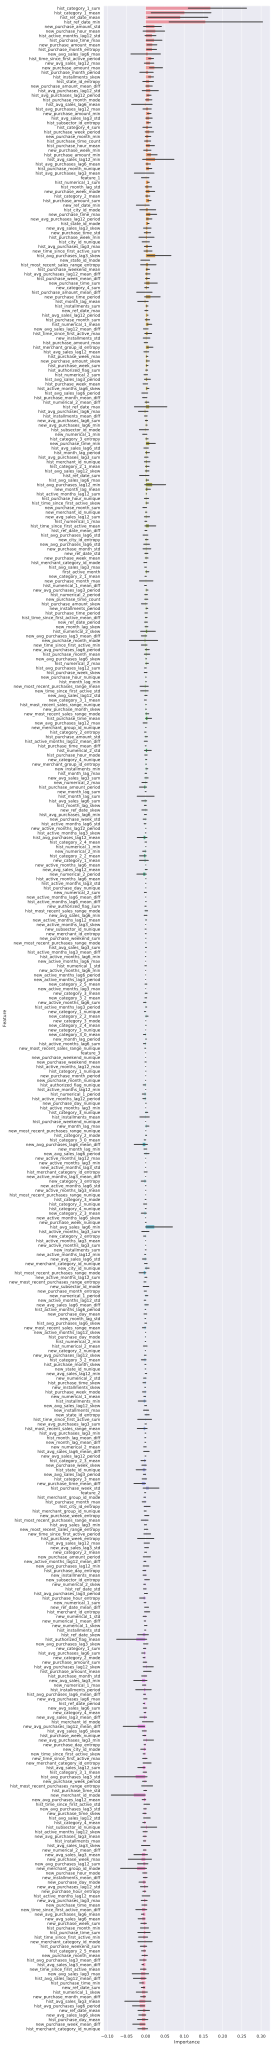

In [16]:
# Plot the feature importances
plt.figure(figsize=(8, 100))
plot_permutation_importance(imp_df)
plt.show()

In [17]:
# TODO: binary search for best cutoff point 
# (re-order features according to new smaller feature importances as you go)
# e.g. if you start out with features 1-8 and 1-4 are best, 
# run model w/ 1-4, compute feature importance and suppose it says 2 and 4 are best
# then for next run use 2 and 4, NOT 1 and 2!

# TODO: use model which predicts outlier and uses model if not outlier?
